# Address Matching Deep Dive

This notebook experiments with different ways of comparing addresses in order to demonstrate the power of parsed address comparison.

In [4]:
import json
import logging
import os
import re
import sys
import time
import warnings
from numbers import Number
from typing import Callable, Dict, List, Literal, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import pycountry
import pytest
import random
import seaborn as sns
import torch
import wandb
from datasets import Dataset
from fuzzywuzzy import fuzz
from langchain.chains import LLMChain
from langchain.globals import set_llm_cache
from langchain_core.caches import InMemoryCache
from langchain_core.outputs import Generation
from langchain_core.output_parsers import JsonOutputParser
from langchain_core._api.deprecation import LangChainDeprecationWarning
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_openai.chat_models import ChatOpenAI
from openai import APIConnectionError, RateLimitError
from postal.parser import parse_address
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sentence_transformers import InputExample, SentenceTransformer, SentencesDataset, SentenceTransformerTrainer, losses
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction, BinaryClassificationEvaluator
from sentence_transformers.model_card import SentenceTransformerModelCardData
from sentence_transformers.training_args import BatchSamplers, SentenceTransformerTrainingArguments
from tenacity import retry
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer, AutoModel, EarlyStoppingCallback, TrainingArguments, Trainer
from transformers.integrations import WandbCallback
from transformers.optimization import get_linear_schedule_with_warmup

from utils import augment_gold_labels, compute_sbert_metrics, compute_classifier_metrics, gold_label_report, preprocess_logits_for_metrics, to_dict

In [5]:
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)

logger = logging.getLogger(__name__)

#### Squelch All `warnings`

[Langchain](https://python.langchain.com/v0.2/docs/introduction/) produces many deprecation warnings as its API is constantly improving. Let's squash them all!

In [6]:
# Suppress all warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=LangChainDeprecationWarning)

#### Configure Weights & Biases

`wandb` needs some environment variables to work.

In [7]:
os.environ["WANDB_LOG_MODEL"] = "end"
os.environ["WANDB_WATCH"] = "all"
os.environ["WANDB_PROJECT"] = "libpostal-reborn"
os.environ["WANDB_DISABLED"] = "false"
os.environ["WANDB_IGNORE_GLOBS"] = ".env"

#### Configure Huggingface APIs

In [8]:
os.environ["HF_ENDPOINT"] = "https://huggingface.co/"

#### Configure Huggingface APIs

Squash any warnings...

In [9]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

#### Configure Pandas to Show More Rows

In [10]:
pd.set_option("display.max_rows", 20)

### Use CUDA or MPS if Avaialable

CPU training and even inference with sentence transformers and deep learning models is quite slow. Since all machine learning in this library is based on [PyTorch](https://pytorch.org/get-started/locally/), we can assign all ML operations to a GPU in this one block of code. Otherwise we default to CPU without acceleration. The notebook is still workable in this mode, you just may need to grab a cup of tea or coffee while you wait for it to train the Sentence-BERT model below.

In [11]:
# Check for CUDA or MPS availability and set the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    logger.debug("Using Apple GPU acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    logger.debug("Using NVIDIA CUDA GPU acceleration")
else:
    device = "cpu"
    logger.debug("Using CPU for ML")

device

device(type='mps')

### Use Weights & Biases for Logging Metrics

Weights & Biases has a free account for individuals with public projects. Using it will produce charts during our training runs that anyone can view. You can create your own project for this notebook and login with that key to log your own training runs.

You may need to run the following command from your shell before the next cell, otherwise you will have to paste your project key into the 

```bash
wandb login
```

In [12]:
# Login to wandb. Comment out if you already haven't via `wandb login` from a CLI
wandb.login()

wandb: Currently logged in as: rjurney. Use `wandb login --relogin` to force relogin


True

## Implementing a Structured Address Matcher

Let's start our exercise by using the structured address data provided by [Libpostal](https://github.com/openvenues/libpostal) to parse them for matching. We write a function for each address part to deal with missing fields without duplicating a lot of logic.

We start with something quite literal and basic. We'll improve it as we go.

In [13]:
# def parse_match_address(address1: str, address2: str) -> Literal[0, 1]:
#     """parse_match_address implements address matching using the precise, parsed structure of addresses."""
#     address1 = to_dict(parse_address(address1))
#     address2 = to_dict(parse_address(address2))

#     def match_road(address1: Dict, address2: Dict) -> Literal[0, 1]:
#         """match_road - literal road matching, negative if either lacks a road"""
#         if ("road" in address1) and ("road" in address2):
#             if address1["road"] == address2["road"]:
#                 logger.debug("road match")
#                 return 1
#             else:
#                 logger.debug("road mismatch")
#                 return 0
#         logger.debug("road mismatch")
#         return 0

#     def match_house_number(address1: Dict, address2: Dict) -> Literal[0, 1]:
#         """match_house_number - literal house number matching, negative if either lacks a house_number"""
#         if ("house_number" in address1) and ("house_number" in address2):
#             if address1["house_number"] == address2["house_number"]:
#                 logger.debug("house_number match")
#                 return 1
#             else:
#                 logger.debug("house_number mismatch")
#                 return 0
#         logger.debug("house_number mistmatch")
#         return 0

#     def match_unit(address1: Dict, address2: Dict) -> Literal[0, 1]:
#         """match_unit - note a missing unit in both is a match"""
#         if "unit" in address1:
#             if "unit" in address2:
#                 logger.debug("unit match")
#                 return 1 if (address1["unit"] == address2["unit"]) else 0
#             else:
#                 logger.debug("unit mismatch")
#                 return 0
#         if "unit" in address2:
#             if "unit" in address1:
#                 logger.debug("unit match")
#                 return 1 if (address1["unit"] == address2["unit"]) else 0
#             else:
#                 logger.debug("unit mismatch")
#                 return 0
#         # Neither address has a unit, which is a default match
#         return 1

#     def match_postcode(address1: Dict, address2: Dict) -> Literal[0, 1]:
#         """match_postcode - literal matching, negative if either lacks a postal code"""
#         if ("postcode" in address1) and ("postcode" in address2):
#             if address1["postcode"] == address2["postcode"]:
#                 logger.debug("postcode match")
#                 return 1
#             else:
#                 logger.debug("postcode mismatch")
#                 return 0
#         logger.debug("postcode mismatch")
#         return 0

#     def match_country(address1: Dict, address2: Dict) -> Literal[0, 1]:
#         """match_country - literal country matching - pass if both don't have one"""
#         if ("country" in address1) and ("country" in address2):
#             if address1["country"] == address2["country"]:
#                 logger.debug("country match")
#                 return 1
#             else:
#                 logger.debug("country mismatch")
#                 return 0
#         # One or none countries should match
#         logger.debug("country match")
#         return 1

#     # Combine the above to get a complete address matcher
#     if (
#         match_road(address1, address2)
#         and match_house_number(address1, address2)
#         and match_unit(address1, address2)
#         and match_postcode(address1, address2)
#         and match_country(address1, address2)
#     ):
#         logger.debug("overall match")
#         return 1
#     else:
#         logger.debug("overall mismatch")
#         return 0

In [14]:
# # Yup down to house_number ...
# parse_match_address(
#     "3413 Sean Way, Lawrenceville, GA 30044",
#     "3413 Sean Way Lawrenceville, GA, 30044",
# )

In [ ]:
# # Yup down to unit ...
# parse_match_address(
#     "120 Ralph McGill Blvd, Apt 101, Atlanta, GA 30308, USA",
#     "120 Ralph McGill Blvd, Apt 101, Atlanta GA 30308",
# )

In [ ]:
# # Nope if only one uses an abbreviation ...
# parse_match_address(
#     "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
#     "120 Ralph McGill Boulevard, Apt 333, Atlanta, GA 30308",
# )

In [ ]:
# # Nope if one character in the streetname is off ...
# parse_match_address(
#     "120 Ralp McGill Blvd, Apt 333, Atlanta, GA 30308",
#     "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
# )

### Literal is Too Precise!

While it is useful to parse addresses and implement literal matching logic as we did above, as the third example indicates, an abbreviation or a single typo results in a mistmatch. We're going to write a more complex, approximate logical matcher below using string distance and text embeddings.

Depending on your application you might relax this criteria to include corner cases such as missing postcodes. Before we get into that, let's create some training and evaluation data using hand-labeled data with an LLM data augmentation strategy to generate a lot of labeled records.

## Create a Dataset of Labeled Address Pairs for Training and Evaluation of Address Matchers

Before improving our precise structured address matcher or trying other approaches, let's create a dataset that enables a more rigorous test of address matching methods. I created two sets of pairs of addresses. Each pair is a `Tuple`, including a description and pair of addresses it describes.

1. `matched_address_pairs` - addresses that look different but that represent the same location. These are matched pairs.
2. `mistmatched_address_pairs` - addresses that look similar but represent different locations. The are mismatched pairs.

These are combined into a global `address_pairs` below.

In [ ]:
matched_address_pairs: List[Tuple[str, str, str]] = [
    (
        "Different directional prefix formats for same address should match",
        "2024 NW 5th Ave, Miami, FL 33127",
        "2024 Northwest 5th Avenue, Miami, Florida 33127",
    ),
    (
        "Abbreviated street type for same address should match",
        "10200 NE 12th St, Bellevue, WA 98003",
        "10200 NE 12th Street, Bellevue, WA 98003",
    ),
    (
        "Common misspellings for same address should match",
        "1600 Pennsylvna Ave NW, Washington, DC 20500",
        "1600 Pennsylvania Avenue NW, Washington, DC 20500",
    ),
    (
        "Different directional prefix formats for same address should match",
        "550 S Hill St, Los Angeles, CA",
        "550 South Hill Street, Los Angeles, California",
    ),
    (
        "Incomplete address vs full address may match",
        "1020 SW 2nd Ave, Portland",
        "1020 SW 2nd Ave, Portland, OR 97204",
    ),
    (
        "Numerical variations for same address should match",
        "Third Ave, New York, NY",
        "3rd Avenue, New York, New York")
    ,
    (
        "Variant format of same address should match",
        "350 Fifth Avenue, New York, NY 10118",
        "Empire State Bldg, 350 5th Ave, NY, NY 10118",
    ),
    (
        "Variant format of same address should match",
        "Çırağan Caddesi No: 32, 34349 Beşiktaş, Istanbul, Turkey",
        "Ciragan Palace Hotel, Ciragan Street 32, Besiktas, Istanbul, TR",
    ),
    (
        "Different character sets for same address should match",
        "北京市朝阳区建国路88号",
        "Běijīng Shì Cháoyáng Qū Jiànguó Lù 88 Hào",
    ),
    (
        "Variant formats of same address should match",
        "上海市黄浦区南京东路318号",
        "上海黄浦南京东路318号"
    ),
    (
        "Variant formats of same address should match",
        "Shànghǎi Shì Huángpǔ Qū Nánjīng Dōng Lù 318 Hào",
        "Shànghǎi Huángpǔ Nánjīng Dōng Lù 318 Hào",
    ),
    (
        "Formal and localized format of same address should match",
        "B-14, Connaught Place, New Delhi, Delhi 110001, India",
        "B-14, CP, ND, DL 110001",
    ),
    (
        "Different character sets for same address should match",
        "16, MG Road, Bangalore, Karnataka 560001, India",
        "16, एमजी रोड, बैंगलोर, कर्नाटक 560001",
    ),
    (
        "Missing state but has postal code and country for same address should match",
        "Pariser Platz 2, 10117 Berlin, Germany",
        "Pariser Platz 2, 10117 Berlin, Berlin, Germany",
    ),
    (
        "Missing state but has postal code and country for same address should match",
        "Marienplatz 1, 80331 Munich, Germany",
        "Marienplatz 1, 80331 Munich, Bavaria, Germany"
    ),
    (
        "Abbreviated vs. full street names for same address should match",
        "123 Main St, Springfield, IL",
        "123 Main Street, Springfield, IL",
    ),
    (
        "Different languages for same address should match",
        "北京市东城区东长安街16号",
        "16 Dongchang'an St, Dongcheng, Beijing, China",
    ),
    (
        "Same address with and without country should match",
        "1600 Amphitheatre Parkway, Mountain View, CA 94043, USA",
        "1600 Amphitheatre Parkway, Mountain View, CA 94043",
    ),
    (
        "Same address with and without country should match",
        "3413 Sean Way, Lawrenceville, GA 30044, U.S.A.",
        "3413 Sean Way, Lawrenceville, Georgia, 30044",
    ),
    (
        "Different levels of detail for the same address may match",
        "221B Baker Street, London, NW1 6XE, UK",
        "221B Baker St, Marylebone, London NW1 6XE",
    ),
    (
        "Same address with and without district / neighborhood names should match",
        "1600 Amphitheatre Parkway, Mountain View, CA 94043, USA",
        "1600 Amphitheatre Parkway, Shoreline, Mountain View, CA 94043, USA",
    ),
    (
        "Including and excluding building names for same address should match",
        "The Empire State Building, 350 5th Ave, New York, NY 10118",
        "350 5th Ave, New York, NY 10118",
    ),
    (
        "Floor bumbers included or excluded for same address should match",
        "350 5th Ave, 86th Floor, New York, NY 10118",
        "350 5th Ave, New York, NY 10118",
    ),
    (
        "Same address incorporates business name or not should match",
        "Google, 1600 Amphitheatre Parkway, Mountain View, CA 94043",
        "1600 Amphitheatre Parkway, Mountain View, CA 94043",
    ),
    (
        "Intersection vs addresss for same location should match",
        "1600 Amphitheatre Parkway at Charleston Road, Mountain View, CA 94043",
        "1600 Amphitheatre Parkway, Mountain View, CA 94043",
    ),
    (
        "Local vs. international formatting for same address should match",
        "221B Baker Street, London, NW1 6XE, UK",
        "221B Baker Street, Marylebone, London, NW1 6XE, United Kingdom",
    ),
    (
        "Addition of parenthetical details for same address should match",
        "Building 4 (East Wing), 123 Tech Park, Silicon Valley, CA 94301",
        "Building 4, 123 Tech Park, Silicon Valley, CA 94301",
    ),
    (
        "Synonyms for street types for same address should match",
        "456 Elm St, Springfield, IL 62704",
        "456 Elm Street, Springfield, IL 62704",
    ),
    (
        "Different language versions of same address should match",
        "16 Rue de la Paix, 75002 Paris, France",
        "16 Peace Street, 75002 Paris, France",
    ),
    (
        "Different terms for unit number for same address should match",
        "500 Fifth Avenue, Apt. 20, New York, NY 10110",
        "500 Fifth Avenue, Suite 20, New York, NY 10110",
    ),
    (
        "Including a business name or not, in same address should match",
        "123 Main St, Springfield, IL",
        "Company ABC, 123 Main St, Springfield, IL",
    ),
    (
        "Typographical errors in street name of same address should match",
        "1600 Amphitheatre Parkway, Mountain View, CA",
        "1600 Amptheatre Parkway, Mountain View, CA",
    ),
    (
        "Typographical errors in same address with country should match",
        "Calle Mayor, 10, 28013 Madrid, España",
        "Calle Mayor, 10, 28013 Madird, España",
    ),
    (
        "Typographical errors in city of same address should match",
        "16 Rue de la Paix, 75002 Paris, France",
        "16 Rue de la Paix, 75002 Pariss, France",
    ),
    (
        "Typographical errors in city of same address should match",
        "Alexanderplatz 1, 10178 Berlin, Deutschland",
        "Alexanderplatz 1, 10178 Berin, Deutschland",
    ),
    (
        "Common typographical errors in same address should match",
        "北京市东城区东长安街1号, 中国",
        "北京市东城区东长安街1号, 中囯",
    ),
    (
        "Numeric or written street number for same address should match",
        "123 4th St, Springfield, IL",
        "123 Fourth St, Springfield, IL",
    ),
    (
        "Punctuation or not in abbreviations for same address should match",
        "10350 NE 12th St, Bellevue, WA 98003",
        "10350 N.E. 12th St., Bellevue, WA 98003",
    ),
    (
        "Normal vs formal country names for same address should match",
        "456 Coastal Lane, Benaulim, Goa, 403716, India",
        "456 Coastal Lane, Benaulim, Goa, 403716, Republic of India",
    ),
    (
        "Normal vs abbreviated country name for same address should match",
        "456 Coastal Lane, Benaulim, Goa, 403716, India",
        "456 Coastal Lane, Benaulim, Goa, 403716, IN",
    ),
    (
        "Missing country in one record can match",
        "3413 Sean Way, Lawrenceville, GA 30044",
        "3413 Sean Way, Lawrenceville, GA 30044, USA",
    ),
]

In [ ]:
mismatched_address_pairs: List[Tuple[str, str, str]] = [
    (
        "Different street numbers means different address",
        "101 Oak Lane, Marietta, GA 30008",
        "102 Oak Lane, Marietta, GA 30008",
    ),
    (
        "Different street names means different address",
        "101 Market Square, Seattle, WA 98039",
        "101 Davis Place, Seattle, WA 98039",
    ),
    (
        "Different street name endings means different address",
        "100 Oak Lane, Atlanta, GA 30306",
        "100 Oak Place, Atlanta, GA 30306",
    ),
    (
        "Different cities means different address",
        "2754 Ralph McGill Blvd, Atlanta, GA",
        "2754 Ralph McGill Blvd, Macon, GA",
    ),
    (
        "Different states means different address",
        "361 Oakhurst Ave., Rome, GA 30149",
        "361 Oakhurst Ave., Rome, NY, 13308",
    ),
    (
        "Different postal codes means different address",
        "76 Providence St, Providence, RI, 02860",
        "76 Providence St, Providence, RI, 02861",
    ),
    (
        "Similar cities in different states, postal codes or countries means different address",
        "100 Main Street, Springfield, IL 62701",
        "100 Main Street, Springfield, MA 01103",
    ),
    (
        "Similar street names with different directions means different address",
        "200 1st Ave, Seattle, WA 98109",
        "200 1st Ave N, Seattle, WA 98109",
    ),
    (
        "Adjacent or nearby building numbers means different address",
        "4800 Oak Street, Kansas City, MO 64112",
        "4800 W Oak Street, Kansas City, MO 64112",
    ),
    (
        "Similar international locations in different countries means different address",
        "33 Queen Street, Auckland 1010, New Zealand",
        "33 Queen Street, Brisbane QLD 4000, Australia",
    ),
    (
        "Close numerical variants are different addresses",
        "75 West 50th Street, New York, NY 10112",
        "50 West 75th Street, New York, NY 10023",
    ),
    (
        "Similar road names can be different addresses",
        "北京市朝阳区朝阳门外大街6号",
        "北京市朝阳区朝阳门内大街6号"
    ),
    (
        "Similar road names can be different addresses",
        "Běijīng Shì Cháoyáng Qū Cháoyángmén Wài Dàjiē 6 Hào",
        "Běijīng Shì Cháoyáng Qū Cháoyángmén Nèi Dàjiē 6 Hào",
    ),
    (
        "Similar building names can be different addresses",
        "上海市徐汇区中山西路200号",
        "上海市长宁区中山西路200号",
    ),
    (
        "Similar but different building names means different address",
        "Shànghǎi Shì Xúhuì Qū Zhōngshān Xī Lù 200 Hào",
        "Shànghǎi Shì Chángníng Qū Zhōngshān Xī Lù 200 Hào",
    ),
    (
        "Different unit numbers means different address",
        "27 Peachtree St, Apt 101, Atlanta, GA 30307",
        "27 Peachtree St, Apt 1213, Atlanta, GA 30307",
    ),
    (
        "Missing unit number in match means different address",
        "27 Peachtree St., Apt 101, Atlanta, GA 30308",
        "27 Peachtree St., Atlanta, GA 30308",
    ),
    (
        "Missing street suffix can mean different address",
        "1020 SW 2nd, Portland, OR 97204",
        "1020 SW 2nd Ave, Portland, OR 97204",
    ),
    (
        "Missing postal code can mean different address",
        "Bouillon Racine: 3, rue Racine, 75006 Paris",
        "Bouillon Racine: 3, rue Racine, Paris",
    ),
    (
        "Different postal codes means different address",
        "1 Infinite Loop, Cupertino, CA 95014",
        "1 Infinite Loop, Cupertino, CA 95015",
    ),
    (
        "Different units in a building means different address",
        "500 Fifth Avenue, Apt. 2A, New York, NY 10110",
        "500 Fifth Avenue, Apt. 2-B, New York, NY 10110",
    ),
    (
        "Street type variations means different address",
        "456 Elm St, Springfield, IL 62704",
        "456 Elm Rd, Springfield, IL 62704",
    ),
    (
        "Different street suffixes means different address",
        "123 Main St, Springfield, IL",
        "123 Main Ave, Springfield, IL",
    ),
    (
        "Different states means different address",
        "Alexanderstraße 7, 10178 Berlin, Germany",
        "Alexanderstraße 7, 20099 Hamburg, Germany",
    ),
    (
        "Different states means different address",
        "200 George St, Sydney, NSW 2000, Australia",
        "200 George St, Melbourne, VIC 3000, Australia",
    ),
    (
        "Different states means different address",
        "100 King St W, Toronto, ON M5X 1A9, Canada",
        "100 King St W, Vancouver, BC V6B 1H8, Canada",
    ),
    (
        "Different street numbers means different address",
        "Unter den Linden 4, 10117 Berlin, Germany",
        "Unter den Linden 5, 10117 Berlin, Germany",
    ),
    (
        "Different street numbers means different address",
        "Avenida Paulista 1000, Bela Vista, São Paulo - SP, 01310-100",
        "Avenida Paulista 200, Bela Vista, São Paulo - SP, 01310-100",
    ),
    (
        "Different countries means different address",
        "123 Main Street, Vancouver, BC V5K 0A1, Canada",
        "123 Main Street, Vancouver, WA 98660, USA",
    ),
    # Some widely diverging examples
    (
        "Completely different addresses that don't match",
        "110 Sejong-daero, Jung-gu, Seoul, South Korea",
        "Avenue Colonel Mondjiba 372, Kinshasa, Gombe, Democratic Republic of the Congo",
    ),
    (
        "Different addresses in the same country that don't match",
        "1234 Manor Plaza, Pacifica, CA 94044",
        "1234 Bly Manor, Pacific Heights, WA 98003",
    ),
    (
        "Different addresses in the same country that don't match",
        "350 5th Ave, New York, NY 10118",
        "1350 El Prado, San Diego, CA 92101",
    ),
    (
        "Completely different addresses that don't match",
        "Rue de la Loi 175, 1040 Brussels",
        "1 Macquarie Street, Sydney, NSW 2000",
    ),
    (
        "Different street names means different address",
        "market Square",
        "davis Place",
    ),
    (
        "Similar but different street numbers",
        "10101 Tensor St.",
        "11010 Tensor St.",
    ),
]

In [ ]:
address_pairs = matched_address_pairs + mismatched_address_pairs

print(f"Matched label address pairs: {len(matched_address_pairs):,}")
print(f"Mismatched label address pairs: {len(mismatched_address_pairs):,}")
print(f"Total label address pairs: {len(address_pairs):,}")

### Create a `pandas.DataFrame` of Hand Labeled Records

We create separate `pd.DataFrames`, `match_df` and `mismatch_df`, to set their labels as 1 or 0. Then we combine them into `combined_df`.

In [ ]:
match_df = pd.DataFrame(matched_address_pairs, columns=["Description", "Address1", "Address2"])
match_df["Label"] = 1

match_df.head(20)

In [ ]:
mismatch_df = pd.DataFrame(mismatched_address_pairs, columns=["Description", "Address1", "Address2"])
mismatch_df["Label"] = 0

mismatch_df.head(20)

### Establish a Gold Labeled Dataset

These are records we have hand-labeled and will use to score our matching models and algorithms.

In [ ]:
gold_df = pd.concat([match_df, mismatch_df], ignore_index=True)

gold_df.head(100)

### Save our Gold Labels

In [ ]:
gold_df.to_csv("data/gold.csv", header=True)

In [16]:
gold_df = pd.read_csv("data/gold.csv")

## Data Augmentation with GPT4o - Multiplying Training Data

We only have 64 training records, but they aren't just random examples. They cover a range of corner cases that should give a model trained via supervised learning clues about the semantics of addresses.

### Human in the Loop Fine-Tuning

We may have enough diversity of examples to generate sufficient training data to cover most addresses (at least North American ones). To improve performance, we can create new hand-labeled examples that fix the errors in `match_df` and `mismatch_df` and re-run the data augmentation pipeline to then re-train and evaluate our matching models. **This gives product managers of AI products a means of product managing their models' predictions.**

### Not Enough Data: Data Augmentation to the Rescue!

Hand labeling is a slow way to create labeled datasets. We need a lot more data than we have, and I can't spare the time to label thousands of records. We could use "mechanical turks" to do this work, but instead we're going to use a data augmentation strategy to use Large Language Models (LLMs) to create semantically similar duplicates for each of our original 29 labeled pairs. The address pair descriptions, along with the match/mis-match label, will guide the LLM in creating semantically similar labeled address pairs. 

### OpenAI GPT4o for Data Augmentation

We are going to use the OpenAI API for GPT4o to ask the model to generate similar records for each record we show it that match the semantics of the description of each pair. This can multiply the number of records by 10, 100 even 1,000 times.

We set the temporature of the LLM high to ensure we get a diverse set of records. 100 records is as many as we can request at once, so we're going to loop 5 times to get approximately 10,000 labeled address pairs.

### How many Record Clones per Existing Example?

For each hand-labeled record, we execute 1 request for 100 records each - giving us about 5,000 examples for each hand-labeled address pair.

In [17]:
CLONES_PER_RUN = 100
RUNS_PER_EXAMPLE = 1

# Append clones per run and runs per example as columns
gold_df["Clones"] = CLONES_PER_RUN
gold_df["Runs"] = RUNS_PER_EXAMPLE

In [18]:
gold_df.head(len(gold_df))

,Unnamed: 0,Description,Address1,Address2,Label,Clones,Runs
0,0,Different directional prefix formats for same ...,"2024 NW 5th Ave, Miami, FL 33127","2024 Northwest 5th Avenue, Miami, Florida 33127",1,100,1
1,1,Abbreviated street type for same address shoul...,"10200 NE 12th St, Bellevue, WA 98003","10200 NE 12th Street, Bellevue, WA 98003",1,100,1
2,2,Common misspellings for same address should match,"1600 Pennsylvna Ave NW, Washington, DC 20500","1600 Pennsylvania Avenue NW, Washington, DC 20500",1,100,1
3,3,Different directional prefix formats for same ...,"550 S Hill St, Los Angeles, CA","550 South Hill Street, Los Angeles, California",1,100,1
4,4,Incomplete address vs full address may match,"1020 SW 2nd Ave, Portland","1020 SW 2nd Ave, Portland, OR 97204",1,100,1
...,...,...,...,...,...,...,...
71,71,Different addresses in the same country that d...,"1234 Manor Plaza, Pacifica, CA 94044","1234 Bly Manor, Pacific Heights, WA 98003",0,100,1
72,72,Different addresses in the same country that d...,"350 5th Ave, New York, NY 10118","1350 El Prado, San Diego, CA 92101",0,100,1
73,73,Completely different addresses that don't match,"Rue de la Loi 175, 1040 Brussels","1 Macquarie Street, Sydney, NSW 2000",0,100,1
74,74,Different street names means different address,market Square,davis Place,0,100,1


## Gold Label Evaluation

Let's define a method to evaluate our models on the original records, rather than on a sample of the augmented records we will generate below. This will let us know in certain terms how different methods of address matching peform.

### Raw Report and Grouped Report

We use a utility function in [utils.py](utils.py) called `gold_label_report` that will apply a list of matching methods to our gold label data and return the raw results and a categorical summary. One DataFrame `raw_df` will contain each address pair, while another `grouped_df` will group them by their `Description` field to better understand each model's performance.

In [ ]:
# def strict_parse_match(row: pd.Series) -> pd.Series:
#     """strict_parse_match Strict address matching"""
#     return parse_match_address(row["Address1"], row["Address2"])

In [ ]:
# # Get raw results and accuracy by type of matching
# raw_df, grouped_df = gold_label_report(gold_df, [strict_parse_match])

### Gold Label Report by `Description`

Let's evaluate how well our address matchers work by category.

In [ ]:
# # Show what it knows, followed by what it don't, in alphabetical order
# grouped_df.sort_values(by="strict_parse_match_acc", ascending=False)

### Strict Matching Results

You can see that strict matching only works for our gold labeled records under certain circumstances, such as when values not essential for a strict match vary. We will improve upon these results below!

### Gold Label Report

Here we can view each example, including what we got right and what we got wrong. This can lead to iterative improvements.

In [ ]:
# true_df = raw_df[raw_df["strict_parse_match_correct"]].reset_index(drop=True)
# print(f"Total accurate matches for strict_parse_match: {len(true_df):,}")

# true_df

In [ ]:
# false_df = raw_df[raw_df["strict_parse_match_correct"] == False].reset_index(drop=True)
# print(f"Total mismatches for strict_parse_match: {len(false_df):,}")

# false_df

### Setup LLM Caching: Sometimes

Our OpenAI LLM request generates a lot of data when asking for a 100 JSON record array. This causes it to occasionally timeout. Accordingly, we setup in memory caching for its requests, so if there is an exception in the request loop for our training examples below, we can simply re-run the cell and it will rapidly return to where it failed and retry, without having to run the previous requests over again.

**NOTE: If we iterate and make multiple LLM calls per record via `RUNS_PER_EXAMPLE`, we can't use LLM caching because it will give us the cached result for all iterative API calls after the first one.**

In [ ]:
# # Set LLM caching up front
# set_llm_cache(InMemoryCache())

In [ ]:
# llm = ChatOpenAI(model="gpt-4o", temperature=0.5)

In [ ]:
# messages: List[Union[SystemMessagePromptTemplate, HumanMessagePromptTemplate]] = [
#     SystemMessagePromptTemplate.from_template(
#         "I need your help with a data science, data augmentation task. I am fine-tuning "
#         "a sentence transformer paraphrase model to match pairs of addresses. I tried "
#         "several embedding models and none of them perform well. They need fine-tuning "
#         "for this task. I have created about 100 example pairs of addresses to serve as training "
#         "data for fine-tuning a SentenceTransformer model. Each record has the fields "
#         "Address1, Address2, a Description of the semantic they express "
#         "(ex. 'different street number') and a Label (1 for positive match, 0 for negative)."
#         "\n\n"
#         "The tasks cover two categories of corner cases or difficult tasks. The first is when similar "
#         "addresses in string distance aren't the same, thus have label 0. "
#         "The second is the opposite: when dissimilar addresses in string distance are the same, "
#         "thus have label 1. The strings you return for Address1 and Address2 should not be literally "
#         "the same.\n\n"
#         "Your task is to read a pair of Addresses, their Description and their Label and generate {Clones} "
#         "different examples that express a similar semantic. Your job is to create variations "
#         "of these records that satisfy the semantic expressed in the description but cover "
#         "widely varying cases of the meaning covering the entire world. Do not literally copy the "
#         "address components. Think methodically. Use what you know about postal addresses to accomplish "
#         "this work."
#         "\n\n"
#         "You should return the result in a valid JSON array of records and nothing else, using the "
#         "fields Address1, Address2, Description and Label."
#     ),
#     # MessagesPlaceholder(variable_name="chat_history"),
#     HumanMessagePromptTemplate.from_template(
#         "Please generate {Clones} different examples that express the same or similar semantic as "
#         "the pair of addresses below based on its Descripton, Label and the Address pairs.\n\n"
#         "Address 1: {Address1}\n"
#         + "Address 2: {Address2}\n"
#         + "Description: {Description}\n"
#         + "Label: {Label}\n"
#     ),
# ]
# prompt = ChatPromptTemplate.from_messages(messages=messages)

# # Everything look alright?
# print(
#     prompt.format(
#         Clones=CLONES_PER_RUN,
#         Address1=gold_df.iloc[0]["Address1"],
#         Address2=gold_df.iloc[0]["Address2"],
#         Description=gold_df.iloc[0]["Description"],
#         Label=gold_df.iloc[0]["Label"],
#     )
# )

In [ ]:
# json_output_parser = JsonOutputParser()

# label_chain = LLMChain(
#     name="label_chain", prompt=prompt, llm=llm, output_parser=json_output_parser, verbose=True
# )

# # Test it once...
# TEST_INDEX = 0

# result = label_chain.run(**gold_df.iloc[TEST_INDEX].to_dict())
# print(result)

### Run Examples through an LLM to Generate Records to Fine-Tune `SentenceTransformers` and other Models

Now that we know our chain works, let's generate some training data! I have created a helper function called `augment_gold_labels` that iterates through our gold labeled data and submits them for augmentation as we have seen above. You can find it in [utils.py](utils.py).

In [ ]:
# augment_results_df = augment_gold_labels(gold_df)

In [ ]:
# augment_results_df.head()

In [ ]:
# # Shuffle our results so we can see different examples - remember we shuffle again in our train_test_split
# augment_results_df = augment_results_df.sample(frac=1.0).reset_index(drop=True)
# augment_results_df.head(50)

### Sanity Check our Descriptions

At one point the model generated 50K examples of one type because my iteration on the LLM instructions went haywire. Let's make sure we have a variety of corner cases in our data. Depending on the prompt, it is possible for the jobs we submitted to return surprising data :)

In [ ]:
# augment_results_df.groupby("Description").count()["Label"]

In [20]:
# If you want to start from here and not run the data augmentation pipeline again...
augment_results_df = pd.read_parquet("data/training.5.parquet")

augment_results_df.head(20)

,Address1,Address2,Description,Label
0,"667 Birchwood Ave, San Diego, CA","667 Birchwood Ln, San Diego, CA",Different street suffixes means different address,0.0
1,"12 Lagoon Lane, Suva, 00000, Fiji","12 Lagoon Lane, Suva, 00000, Republic of Fiji",Normal vs formal country names for same addres...,1.0
2,"1010 Spruce Street, Suite 24TT, Baltimore, MD ...","1010 Spruce Street, Suite 24-UU, Baltimore, MD...",Different units in a building means different ...,0.0
3,"Bagan, Mandalay Region, Myanmar","Bagan, Mandalay Region, Myanmr",Typographical errors in city of same address s...,1.0
4,"One Market Street, San Francisco, CA 94105, USA","One Market Street, San Francisco, CA 94105, US",Typographical errors in city of same address s...,1.0
5,"Statue of Liberty, Liberty Island, New York, N...","Statue of Liberty, Liberty Island, New York, N...",Missing state but has postal code and country ...,1.0
6,"5353 Sequoia Street, Yerevan, 0001, Armenia","5353 Sequoia Street, Yerevan, 0001",Same address with and without country should m...,1.0
7,"10 Downing Street, Westminster, London SW1A 2AA","10 Downing Lane, Westminster, London SW1A 2AA",Similar road names can be different addresses,0.0
8,"1 Infinite Loop, Cupertino, CA 95014","4 Infinite Loop, Cupertino, CA 95014",Different street numbers means different address,0.0
9,"Niagara Falls, NY 14303, USA","Niagara Falls, New York 14303, USA",Variant formats of same address should match,1.0


In [ ]:
# Save for posterity
# augment_results_df.to_parquet("data/training.5.parquet")

### Data Augmentation Complete!

Starting by hand labeling under 100 records and iterating a few times on data augmentation instructions for GPT4o, we have multiplied them by many times to get almost 10,000 synthetic records! This is enough to fine-tune a `SentenceTransformer` or semantic text similarity classifier model. GPT4o is a powerful tool for data augmentation! This can work for a variety of problems.

LLM based data augmentation is a powerful tool for your data labeling toolbox.

# Comparing Different Approaches to Address Matching

Now we're going to compare the following methods of address matching:

1) String Distance - we'll use PyPI library [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/0.6.1/) to compute the Levenshtein ratio and partial ratio of how many edits are required to match the address strings. There are times this works well, and there are times it couldn't be more wrong.
2) Text Embeddings - we'll use transfer learning to load an existing [SentenceTransformer](https://sbert.net) model to sentence encode pairs of addresses to create fixed-length embeddings for each address and then compute a similarity score via [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). This won't work without fine-tuning, so we fine-tune the model to the task.
3) Deep Matching Model - We'll train a deep semantic textual similarity classification model that will use Siamese BERT networks as in [Sentence-BERT](https://arxiv.org/abs/1908.10084) to classify address pairs as matching or not matching.

## Imprecise Country Matching with `pycountry`

The structured address has fields that each have their own semantics. Tools specific to a field can help match address components.

If you have any valid ISO nation abbreviation or long form name, [pycountry](https://pypi.org/project/pycountry/) is a PyPi module that can retrieve the actual country for it. This enables efficient comparison. Let's use that to convert the mismatched Singapore references in these records to the same entity.

In [ ]:
# def match_country_names(country1: str, country2: str) -> Literal[0, 1]:
#     """match_country_strings - compare and match varying country formats using pycountry"""

#     # Remove any punctuation from the country
#     def remove_punctuation(country: str) -> str:
#         # Use re.sub to replace all punctuation characters with an empty string
#         return re.sub(r"[^\w\s]", "", country)

#     def multi_lookup(**kwargs):
#         """Try each key until we retrieve a result"""
#         for arg, value in kwargs.items():
#             result = pycountry.countries.get(**{arg: value})
#             if result:
#                 return result

#     def get_args(country: str):
#         """Compose pycountries.countries.get arguments dict based on length of country string"""
#         args = {}
#         if country and len(country) == 2:
#             args["alpha_2"] = country
#         elif country and len(country) == 3:
#             args["alpha_3"] = country
#         elif country:
#             args["name"] = country
#             args["common_name"] = country
#             args["official_name"] = country
#         return args

#     try:
#         pycountry1 = multi_lookup(**get_args(remove_punctuation(country1)))
#         pycountry2 = multi_lookup(**get_args(remove_punctuation(country2)))

#         return 1 if pycountry1.name == pycountry2.name else 0
#     except AttributeError:
#         return 0

In [ ]:
# match_country_names("sg", "singapore")

In [ ]:
# match_country_names("usa", "united states")

In [ ]:
# # Didn't match until I added and called remove_punctuation(country: str) -> str
# match_country_names("U.S.A.", "United States of America")

In [ ]:
# match_country_names("USA", "MEX")

In [ ]:
# match_country_names("United States", "United Mexican States")

### Country Parsing in Structured Matching

Let's use our new method `match_pycountry(country1: str, country2: str) -> Literal[0, 1]` matcher to improve our original structured matcher. This will allow it to contain varying country formats and still match. This makes the matcher more robust. 

In order to make this work we have to refactor our code to create matching functions for each field. Note that we are leaving out matching states, as they aren't required if the road name, number, unit and postal code match.

In [ ]:
# def parse_match_address_country(address1: str, address2: str) -> Literal[0, 1]:
#     """parse_match_address_country implements address matching like parse_match_address() but with pycountry country matching"""
#     address1 = to_dict(parse_address(address1))
#     address2 = to_dict(parse_address(address2))

#     def match_road(address1: str, address2: str) -> Literal[0, 1]:
#         """match_road - literal road matching, negative if either lacks a road"""
#         if ("road" in address1) and ("road" in address2):
#             if address1["road"] == address2["road"]:
#                 logger.debug("road match")
#                 return 1
#             else:
#                 logger.debug("road mismatch")
#                 return 0
#         logger.debug("road mismatch")
#         return 0

#     def match_house_number(address1: str, address2: str) -> Literal[0, 1]:
#         """match_house_number - literal house number matching, negative if either lacks a house_number"""
#         if ("house_number" in address1) and ("house_number" in address2):
#             if address1["house_number"] == address2["house_number"]:
#                 logger.debug("house_number match")
#                 return 1
#             else:
#                 logger.debug("house_number mismatch")
#                 return 0
#         logger.debug("house_number mistmatch")
#         return 0

#     def match_unit(address1: str, address2: str) -> Literal[0, 1]:
#         """match_unit - note a missing unit in both is a match"""
#         if "unit" in address1:
#             if "unit" in address2:
#                 logger.debug("unit match")
#                 return 1 if (address1["unit"] == address2["unit"]) else 0
#             else:
#                 logger.debug("unit mismatch")
#                 return 0
#         if "unit" in address2:
#             if "unit" in address1:
#                 logger.debug("unit match")
#                 return 1 if (address1["unit"] == address2["unit"]) else 0
#             else:
#                 logger.debug("unit mismatch")
#                 return 0
#         # Neither address has a unit, which is a default match
#         return 1

#     def match_postcode(address1: str, address2: str) -> Literal[0, 1]:
#         """match_postcode - literal matching, negative if either lacks a postal code"""
#         if ("postcode" in address1) and ("postcode" in address2):
#             if address1["postcode"] == address2["postcode"]:
#                 logger.debug("postcode match")
#                 return 1
#             else:
#                 logger.debug("postcode mismatch")
#                 return 0
#         logger.debug("postcode mismatch")
#         return 0

#     def match_country(address1: str, address2: str) -> Literal[0, 1]:
#         """match_country - semantic country matching with pycountry via match_country_names(country1, country2)"""
#         if ("country" in address1) and ("country" in address2):
#             if match_country_names(address1["country"], address2["country"]):
#                 logger.debug("country match")
#                 return 1
#             else:
#                 logger.debug("country mismatch")
#                 return 0
#         # One or none countries should match
#         logger.debug("country match")
#         return 1

#     # Combine the above to get a complete address matcher
#     if (
#         match_road(address1, address2)
#         and match_house_number(address1, address2)
#         and match_unit(address1, address2)
#         and match_postcode(address1, address2)
#         # Our only non-exact match - default to 1, match
#         and match_country(address1, address2)
#     ):
#         logger.debug("overall match")
#         return 1
#     else:
#         logger.debug("overall mismatch")
#         return 0

In [ ]:
# parse_match_address_country(
#     "100 Roxas Blvd, Ermita, Manila, 1000 Metro Manila, PH",
#     "100 Roxas Blvd, Ermita, Manila, 1000 Metro Manila, Republic of the Philippines"
# )

In [ ]:
# # Defaults to match if no countries are provided
# parse_match_address_country(
#     "100 King St W, Toronto, ON M5X 1A9",
#     "100 King St W, Toronto, ON M5X 1A9",
# )

In [ ]:
# # Defaults to match if only one address has country
# parse_match_address_country(
#     "100 King St W, Toronto, ON M5X 1A9",
#     "100 King St W, Toronto, ON M5X 1A9, Canada",
# )

In [ ]:
# # Verify mismatch
# parse_match_address_country(
#     "Bosque de Chapultepec I Secc, Miguel Hidalgo, 11850 Ciudad de México, CDMX, Mexico",
#     "Bosque de Chapultepec I Secc, Miguel Hidalgo, 11850 Ciudad de México, CDMX, USA"
# )

### Gold Label Validation

We need to evaluate this new method against our gold labeled data.

In [ ]:
# def parse_match_country(row: pd.Series) -> pd.Series:
#     """parse_match Strict address matching"""
#     return parse_match_address_country(row["Address1"], row["Address2"])

In [ ]:
# raw_df, grouped_df = gold_label_report(gold_df, [strict_parse_match, parse_match_country])

In [ ]:
# grouped_df

In [ ]:
# true_df = raw_df[raw_df["parse_match_country_correct"]]
# print(f"Total accurate matches for strict_parse_match: {len(true_df):,}")

# true_df.sort_values(by="Description").reset_index(drop=True)

In [ ]:
# false_df = raw_df[raw_df["parse_match_country_correct"] == False]
# print(f"Total mismatches for strict_parse_match: {len(false_df):,}")

# false_df.sort_values(by="Description").reset_index(drop=True)

# Machine Learning Approaches to Address Matching

In this section we pursue two machine learning approaches to address matching, in order of sophistication. First we fine-tune a pre-trained embedding model to our task, try it on our data and search for a threshold similarity that results in good performance for our address matching problem. Second we build a Siamese BERT network model based on [Sentence-BERT](https://arxiv.org/abs/1908.10084) to classify pairs of addresses as match or mismatch. We will train it using the same dataset we use to fine-tune a sentence transformer, and if we have enough training data this will likely be a more powerful approach.

## Text Embeddings, Sentence Encoding, `SentenceTransformers`, Vector Distance and Cosine Similarity

Text embeddings are trained on large volumes of text that include addresses. As a result they have some understanding of address strings and can do a form of semantic comparison that is less explicit than logical comparisons with address parsing. They're an important benchmark to explore. Huggingface has an excellent [introduction to sentence similarity](https://huggingface.co/tasks/sentence-similarity).

In our first machine learning approach, we are going to use transfer learning to load a pre-trained [sentence transformer](https://sbert.net) models from huggingface. We will use the training data we've prepared to fine-tune this model to our task, before rigorously evaluating it along with our other approaches.

Sentence transformers sentence encode strings of different distances into fixed-length vectors, a technique called sentence encoding. Once two address strings are embedded into a pair of equal length vectors, they can be compared with cosine similarity to get a distance, the inverse of which is a similarity score.

### Convert our `pd.DataFrame` to a `List[sentence_transformers.InputExample]`

First we need to convert our Pandas `DataFrame` to a list of sentence transformer input examples. `InputExamples` require two fields `texts=List[str, str]` and `label`.

In [21]:
train_df, tmp_df = train_test_split(augment_results_df, test_size=0.2, shuffle=True)
eval_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, shuffle=True)

train_dataset = Dataset.from_dict({
    "sentence1": train_df["Address1"].tolist(),
    "sentence2": train_df["Address2"].tolist(),
    "label": train_df["Label"].tolist(),
})

eval_dataset = Dataset.from_dict({
    "sentence1": eval_df["Address1"].tolist(),
    "sentence2": eval_df["Address2"].tolist(),
    "label": eval_df["Label"].tolist(),
})

test_dataset = Dataset.from_dict({
    "sentence1": test_df["Address1"].tolist(),
    "sentence2": test_df["Address2"].tolist(),
    "label": test_df["Label"].tolist(),
})

print(f"Training data:   {len(train_df):,}")
print(f"Validation data: {len(eval_df):,}")
print(f"Test data        {len(eval_df):,}")

Training data:   3,928
Validation data: 491
Test data        491


### Configure Fine-Tuning, Initialize a `SentenceTransformer`

To use the training data we prepared to fine-tune a `SentenceTransformer`, we need to select and load a pre-trained model from Huggingface Hub. Here are some models you can try:

* [sentence-transformers/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) - multilingual paraphrase models are designed to compare sentences in terms of their semantics.
* [BAAI/bge-m3](https://huggingface.co/BAAI/bge-m3) - a robust, multilingual model optimized for a variety of tasks
* [sentence-transformers/paraphrase-multilingual-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2) - MPNet is another paraphrase model architecture we can fine-tune for address comparison
* [sentence-transformers/all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) - a top performing MPNet model

In [24]:
SBERT_MODEL = "paraphrase-multilingual-MiniLM-L12-v2"
VARIANT = "original"
MODEL_SAVE_NAME = (SBERT_MODEL + "-" + VARIANT).replace("/", "-")

EPOCHS = 6
BATCH_SIZE = 32
PATIENCE = 2
LEARNING_RATE = .00005
DATASET_MULTIPLE = CLONES_PER_RUN * RUNS_PER_EXAMPLE
SBERT_OUTPUT_FOLDER = f"data/fine-tuned-sbert-{MODEL_SAVE_NAME}"
SAVE_EVAL_STEPS = 100

### Initialize Weights & Biases

Weights and biases `wandb` package makes it simple to monitor the performance of your training runs.

In [25]:
# Initialize Weights & Biases
wandb.init(
    entity="rjurney",
    # set the wandb project where this run will be logged
    project="libpostal-reborn",
    # track hyperparameters and run metadata
    config={
        "variant": VARIANT,
        "dataset_multiple": DATASET_MULTIPLE,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "patience": PATIENCE,
        "learning_rate": LEARNING_RATE,
        "sbert_model": SBERT_MODEL,
        "sbert_output_folder": SBERT_OUTPUT_FOLDER,
        "save_eval_steps": SAVE_EVAL_STEPS,
    },
)

### Setup our `SentenceTransformer` Model

Choose the model to fine-tune above in `SBERT_MODEL` and instantiate it below.

In [26]:
sbert_model = SentenceTransformer(
    SBERT_MODEL,
    device=device,
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name=f"{SBERT_MODEL}-address-matcher-{VARIANT}",
    ),
)

### Evaluate our Model Before Fine-Tuning

Let's see what it can do without fine-tuning, then we'll compare our subjective results afterwards. This won't work very well, fine-tuning is required!

In [27]:
def sbert_compare(address1: str, address2: str) -> float:
    """sbert_compare - sentence encode each address into a fixed-length text embedding.
    Fixed-length means they can be compared with cosine similarity."""
    embedding1 = sbert_model.encode(address1)
    embedding2 = sbert_model.encode(address2)

    # Compute cosine similarity
    return 1 - distance.cosine(embedding1, embedding2)


def sbert_match(row: pd.Series) -> pd.Series:
    """sbert_match - SentenceTransformer address matching, float iytoyt"""
    return sbert_compare(row["Address1"], row["Address2"])


def sbert_compare_binary(address1: str, address2: str, threshold: float = 0.5) -> Literal[0, 1]:
    """sbert_match - compare and return a binary match"""
    similarity = sbert_compare(address1, address2)
    return 1 if similarity >= threshold else 0


def sbert_match_binary(row: pd.Series, threshold: float = 0.5) -> pd.Series:
    """sbert_match_binary - SentenceTransformer address matching, binary output"""
    return sbert_compare_binary(row["Address1"], row["Address2"], threshold=threshold)

In [28]:
# Still too similar - very hard to train them away from this behavior!
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "102 Oak Lane, Atlanta, GA 30308",
)

0.9887310599046897

In [30]:
# A little bit further away ...
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "101 Oak Ln., Atlanta, GA 30308",
)

0.9080112054372381

In [31]:
# Properly distant ...
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "1202 Oak Rd., Lawrenceville, GA 30304",
)

0.7771668960380212

In [32]:
# Properly similar ...
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way, Lawrenceville, GA 30044, USA",
)

0.9754176576820044

### Evaluate the Test Set with the Untrained Model

Let's see how well the [paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) model does on its own. This is our baseline score.

In [33]:
# Initialize the evaluator
binary_acc_evaluator = BinaryClassificationEvaluator(
    sentences1=eval_dataset["sentence1"],
    sentences2=eval_dataset["sentence2"],
    labels=eval_dataset["label"],
    name=SBERT_MODEL,
)
binary_acc_evaluator(sbert_model)

{'paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy': 0.6069246435845214,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold': 0.6396439075469971,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_f1': 0.7388362652232746,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold': 0.6396439075469971,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_precision': 0.5909090909090909,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_recall': 0.9855595667870036,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_ap': 0.5920729193825374,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy': 0.6171079429735234,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold': 20.27435302734375,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_f1': 0.7270341207349081,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold': 7.225688934326172,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_precision': 0.5711340206185567,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_recall': 1.0,
 'paraphrase-

### Computing Metrics with `sklearn.metrics`

We use [scikit-learn metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) instead to compute our evaluation metrics.

In [34]:
# This will rapidly train the embedding model. MultipleNegativesRankingLoss did not work.
loss = losses.ContrastiveLoss(model=sbert_model)

sbert_args = SentenceTransformerTrainingArguments(
    output_dir=SBERT_OUTPUT_FOLDER,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_ratio=0.1,
    run_name=SBERT_MODEL,
    load_best_model_at_end=True,
    save_steps=SAVE_EVAL_STEPS,
    eval_steps=SAVE_EVAL_STEPS,
    save_strategy="steps",
    eval_strategy="steps",
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    learning_rate=LEARNING_RATE,
)

trainer = SentenceTransformerTrainer(
    model=sbert_model,
    args=sbert_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=binary_acc_evaluator,
    compute_metrics=compute_sbert_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

trainer.evaluate()
trainer.train()

Step,Training Loss,Validation Loss,Paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy,Paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Cosine F1,Paraphrase-multilingual-minilm-l12-v2 Cosine F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Cosine Precision,Paraphrase-multilingual-minilm-l12-v2 Cosine Recall,Paraphrase-multilingual-minilm-l12-v2 Cosine Ap,Paraphrase-multilingual-minilm-l12-v2 Dot Accuracy,Paraphrase-multilingual-minilm-l12-v2 Dot Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Dot F1,Paraphrase-multilingual-minilm-l12-v2 Dot F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Dot Precision,Paraphrase-multilingual-minilm-l12-v2 Dot Recall,Paraphrase-multilingual-minilm-l12-v2 Dot Ap,Paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy,Paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Manhattan F1,Paraphrase-multilingual-minilm-l12-v2 Manhattan F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Manhattan Precision,Paraphrase-multilingual-minilm-l12-v2 Manhattan Recall,Paraphrase-multilingual-minilm-l12-v2 Manhattan Ap,Paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy,Paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Euclidean F1,Paraphrase-multilingual-minilm-l12-v2 Euclidean F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Euclidean Precision,Paraphrase-multilingual-minilm-l12-v2 Euclidean Recall,Paraphrase-multilingual-minilm-l12-v2 Euclidean Ap,Paraphrase-multilingual-minilm-l12-v2 Max Accuracy,Paraphrase-multilingual-minilm-l12-v2 Max Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Max F1,Paraphrase-multilingual-minilm-l12-v2 Max F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Max Precision,Paraphrase-multilingual-minilm-l12-v2 Max Recall,Paraphrase-multilingual-minilm-l12-v2 Max Ap
100,No log,0.011554,0.904277,0.852615,0.918544,0.843050,0.883333,0.956679,0.967409,0.788187,9.497717,0.834395,9.497717,0.746439,0.945848,0.892640,0.890020,34.788689,0.906897,35.277390,0.867987,0.949458,0.953795,0.887984,2.222294,0.904679,2.222294,0.870000,0.942238,0.953876,0.904277,34.788689,0.918544,35.277390,0.883333,0.956679,0.967409
200,No log,0.005217,0.973523,0.865150,0.976407,0.854569,0.981752,0.971119,0.995055,0.863544,10.222496,0.884808,9.696405,0.822981,0.956679,0.940242,0.955193,32.666565,0.959707,33.100555,0.973978,0.945848,0.990034,0.957230,2.146176,0.961749,2.146176,0.970588,0.953069,0.990273,0.973523,32.666565,0.976407,33.100555,0.981752,0.971119,0.995055
300,No log,0.004038,0.979633,0.847553,0.982143,0.847553,0.971731,0.992780,0.997249,0.885947,11.422576,0.905085,10.562412,0.853035,0.963899,0.949264,0.961303,37.350021,0.966011,37.350021,0.957447,0.974729,0.994421,0.961303,2.307831,0.966011,2.417454,0.957447,0.974729,0.994543,0.979633,37.350021,0.982143,37.350021,0.971731,0.992780,0.997249
400,No log,0.003004,0.987780,0.855156,0.989170,0.855156,0.989170,0.989170,0.998681,0.898167,12.107885,0.913793,12.107885,0.874587,0.956679,0.962359,0.971487,35.156326,0.974545,35.156326,0.981685,0.967509,0.997168,0.971487,2.173794,0.974453,2.173794,0.985240,0.963899,0.997223,0.987780,35.156326,0.989170,35.156326,0.989170,0.989170,0.998681
500,0.008300,0.002565,0.987780,0.868518,0.989209,0.852644,0.985663,0.992780,0.998767,0.904277,12.965615,0.915315,12.965615,0.913669,0.916968,0.958287,0.975560,37.814823,0.978417,39.922844,0.974910,0.981949,0.997509,0.975560,2.452184,0.978417,2.580140,0.974910,0.981949,0.997582,0.987780,37.814823,0.989209,39.922844,0.985663,0.992780,0.998767
600,0.008300,0.002652,0.987780,0.878015,0.989209,0.854953,0.985663,0.992780,0.998510,0.894094,13.424889,0.906810,12.890186,0.900356,0.913357,0.962727,0.977597,39.009544,0.980251,41.100811,0.975000,0.985560,0.997335,0.977597,2.375875,0.980251,2.676310,0.975000,0.985560,0.997350,0.987780,39.009544,0.989209,41.100811,0.985663,0.992780,0.998510
700,0.008300,0.002573,0

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

TrainOutput(global_step=700, training_loss=0.006350714436599187, metrics={'train_runtime': 119.8078, 'train_samples_per_second': 196.715, 'train_steps_per_second': 6.16, 'total_flos': 0.0, 'train_loss': 0.006350714436599187, 'epoch': 5.691056910569106})

In [35]:
trainer.evaluate()

{'eval_loss': 0.0025646702852100134,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy': 0.9877800407331976,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold': 0.8685182332992554,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_f1': 0.9892086330935251,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold': 0.8526440858840942,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_precision': 0.985663082437276,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_recall': 0.9927797833935018,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_ap': 0.9987669767054413,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy': 0.9042769857433809,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold': 12.965615272521973,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_f1': 0.9153153153153154,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold': 12.965615272521973,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_preci

In [36]:
wandb.finish()

eval/loss,█▃▁▁▁▁▁▁▁
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,▁▆███████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,▁▇█▇▇██▇█
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,▁▇███████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,▁▆███████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,▁████████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,▁▆███████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,▇▁▄█▇████
eval/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,▁▅▇██████
eval/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold,█▁▁▂▃▃▄▄▃
eval/paraphrase-multilingual-MiniLM-L12-v2_dot_ap,▁▆▇██████


### Try the Model from Our Best Epoch

We fine-tuned the model for `EPOCHS` nubmer of epochs, but the last epoch isn't always best. The `TrainingArgument` `load_best_model_at_end=True` loads the model at the end.

Another way to load the best model is to load our output folder and evaluate that `SentenceTransformer` on some examples to get a gestalt sense for its performance.

```python
sbert_model = SentenceTransformer(OUTPUT_FOLDER, device=device)
```

In [37]:
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "102 Oak Lane, Atlanta, GA 30308",
)

0.5302506793214702

In [38]:
sbert_compare(
    "101 Oak Lane, Macon, GA 30308",
    "101 Oak Lane, Atlanta, GA 30408",
)

0.7293249801135814

In [39]:
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "101 Oak Ln., Atlanta, GA 30308",
)

0.9010656507403272

In [40]:
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "1202 Oak Rd., Lawrenceville, GA 30304",
)

0.4405346737968603

In [41]:
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way, Lawrenceville, GA 30044, USA",
)

0.9820233464356506

### Evaluate ROC Curve to Determine Optimum Similarity Threshold

0.5 is an arbitrary line on which to divide positive (match, 1) and negative (mismatch, 0). Let's evaluate the ROC Curve of the F1 score to see what it should be set to. Recall that the `sbert_match` function has a `threshold: float = 0.5` argument.

#### Evaluate on our Augmented Test Dataset

First we'll evaluate the ROC curve on our augmented test dataset.

In [42]:
y_true = test_df["Label"]
y_scores = test_df.apply(sbert_match, axis=1)

In [43]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.8782018335853125
Best F1 Score: 0.9782608695652174
AUC-ROC: 0.9970815479604576


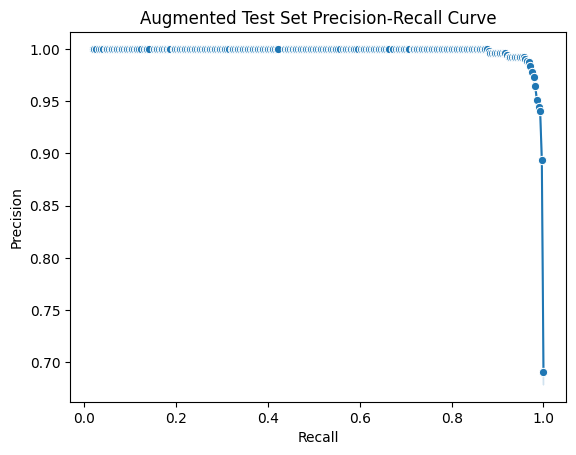

In [44]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Augmented Test Set Precision-Recall Curve')
plt.show()

### Plot a ROC Curve for our Gold Labeled Data

We need to see the ROC Curve for our gold labeled data as well. We care more about performance on this data.

In [45]:
y_true = gold_df["Label"]
y_scores = gold_df.apply(sbert_match, axis=1)

In [46]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.9324278911300723
Best F1 Score: 0.8433734939759037
AUC-ROC: 0.8285714285714285


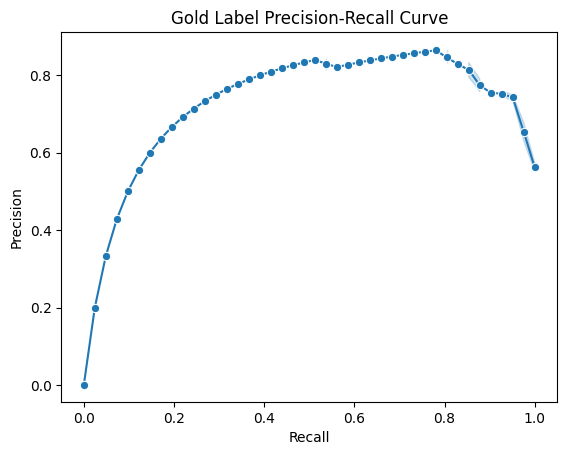

In [47]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gold Label Precision-Recall Curve')
plt.show()

### Debugging Errors on our Gold Labels

Let's evaluate the data using our `gold_label_report` function with the best F1 score. Then we can view the errors and figure out where our model is failing.

In [49]:
raw_df, grouped_df = gold_label_report(
    gold_df,
    [
        # strict_parse_match,
        # parse_match_country,
        sbert_match_binary,
    ],
    threshold=best_threshold
)

#### Label Description Group Analysis

You can see the types of address pairs we are failing on. This can guide our data augmentation / programmatic labeling work at a high level.

In [50]:
grouped_df.head()

,sbert_match_binary_acc
Description,
Abbreviated street type for same address should match,1.0
Abbreviated vs. full street names for same address should match,1.0
Addition of parenthetical details for same address should match,1.0
Adjacent or nearby building numbers means different address,1.0
Close numerical variants are different addresses,0.0


In [51]:
grouped_df["sbert_match_binary_acc"].sort_values()

Description
Incomplete address vs full address may match                                   0.0
Missing street suffix can mean different address                               0.0
Formal and localized format of same address should match                       0.0
Similar but different street numbers                                           0.0
Different units in a building means different address                          0.0
                                                                              ... 
Missing country in one record can match                                        1.0
Missing postal code can mean different address                                 1.0
Missing state but has postal code and country for same address should match    1.0
Normal vs formal country names for same address should match                   1.0
Variant formats of same address should match                                   1.0
Name: sbert_match_binary_acc, Length: 59, dtype: float64

#### What it Got Right ...

In [52]:
# Truthiness analysis
correct_df = raw_df[raw_df["sbert_match_binary_correct"]].reset_index()
print(f"Number correct: {len(correct_df):,}")

correct_df

Number correct: 63


,index,Description,Address1,Address2,Label,sbert_match_binary,sbert_match_binary_correct
0,0,Different directional prefix formats for same ...,"2024 NW 5th Ave, Miami, FL 33127","2024 Northwest 5th Avenue, Miami, Florida 33127",1,1,True
1,1,Abbreviated street type for same address shoul...,"10200 NE 12th St, Bellevue, WA 98003","10200 NE 12th Street, Bellevue, WA 98003",1,1,True
2,2,Common misspellings for same address should match,"1600 Pennsylvna Ave NW, Washington, DC 20500","1600 Pennsylvania Avenue NW, Washington, DC 20500",1,1,True
3,3,Different directional prefix formats for same ...,"550 S Hill St, Los Angeles, CA","550 South Hill Street, Los Angeles, California",1,1,True
4,5,Numerical variations for same address should m...,"Third Ave, New York, NY","3rd Avenue, New York, New York",1,1,True
...,...,...,...,...,...,...,...
58,71,Different addresses in the same country that d...,"1234 Manor Plaza, Pacifica, CA 94044","1234 Bly Manor, Pacific Heights, WA 98003",0,0,True
59,72,Different addresses in the same country that d...,"350 5th Ave, New York, NY 10118","1350 El Prado, San Diego, CA 92101",0,0,True
60,73,Completely different addresses that don't match,"Rue de la Loi 175, 1040 Brussels","1 Macquarie Street, Sydney, NSW 2000",0,0,True
61,74,Different street names means different address,market Square,davis Place,0,0,True


In [53]:
# Error analysis
wrong_df = raw_df[raw_df["sbert_match_binary_correct"] == False].reset_index()
print(f"Number wrong: {len(wrong_df):,}")

wrong_df

Number wrong: 13


,index,Description,Address1,Address2,Label,sbert_match_binary,sbert_match_binary_correct
0,4,Incomplete address vs full address may match,"1020 SW 2nd Ave, Portland","1020 SW 2nd Ave, Portland, OR 97204",1,0,False
1,7,Variant format of same address should match,"Çırağan Caddesi No: 32, 34349 Beşiktaş, Istanb...","Ciragan Palace Hotel, Ciragan Street 32, Besik...",1,0,False
2,11,Formal and localized format of same address sh...,"B-14, Connaught Place, New Delhi, Delhi 110001...","B-14, CP, ND, DL 110001",1,0,False
3,16,Different languages for same address should match,北京市东城区东长安街16号,"16 Dongchang'an St, Dongcheng, Beijing, China",1,0,False
4,28,Different language versions of same address sh...,"16 Rue de la Paix, 75002 Paris, France","16 Peace Street, 75002 Paris, France",1,0,False
5,32,Typographical errors in same address with coun...,"Calle Mayor, 10, 28013 Madrid, España","Calle Mayor, 10, 28013 Madird, España",1,0,False
6,49,Adjacent or nearby building numbers means diff...,"4800 Oak Street, Kansas City, MO 64112","4800 W Oak Street, Kansas City, MO 64112",0,1,False
7,52,Similar road names can be different addresses,北京市朝阳区朝阳门外大街6号,北京市朝阳区朝阳门内大街6号,0,1,False
8,53,Similar road names can be different addresses,Běijīng Shì Cháoyáng Qū Cháoyángmén Wài Dàjiē ...,Běijīng Shì Cháoyáng Qū Cháoyángmén Nèi Dàjiē ...,0,1,False
9,54,Similar building names can be different addresses,上海市徐汇区中山西路200号,上海市长宁区中山西路200号,0,1,False


# Fuzzy, Structured Address Matching with Libpostal and Vector Distance

There seems to be merit to both structured and embedding approaches to address matching. Let's see how an approximate approach to matching parsed address components might help.

## Combining an Address Parsing and Embedding Approach

Libpostal is a powerful parsing model, and it seems like parsing is a logical first step in matching addresses. Some logical combinations of fields should result in a match, while some should not. This logic can be programmed by a human, provided fuzzy matching is available at the field level. `101 Oak Lane` should match `101 Oak Ln` but not `102 Oak Lane`. `street_name` and `street_number` are separate fields in an address parsed by Libpostal. What is we got some machine learning help with field-level matching?

In [ ]:
# sbert_compare("Oak Lane", "Oak Ln.")

In [ ]:
# sbert_compare("Cheer Lane", "Cheer Road")

In [ ]:
# sbert_compare("101", "110")

In [ ]:
# sbert_compare("5th", "Fifth")

In [ ]:
# sbert_compare("USA", "United States")

In [ ]:
# sbert_compare("30044", "30308")
parse_address("3413 Sean Way")

## Fine-Tuning a Lowercase `SentenceTransformer`

My first pass at this method did not work whatsoever - the performance of the matcher was abysmal. This was because Libpostal *lowercases* addresses when it parses them, and I did NOT do that to the training data on a first pass :) Once I did that and retrained below - things worked much better!

### Lowercase our Dataset

In [ ]:
# lower_augment_results_df = augment_results_df.copy(deep=True)

# lower_augment_results_df["Address1"] = lower_augment_results_df["Address1"].str.lower()
# lower_augment_results_df["Address2"] = lower_augment_results_df["Address2"].str.lower()

In [ ]:
# train_df, tmp_df = train_test_split(lower_augment_results_df, test_size=0.2, shuffle=True)
# eval_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, shuffle=True)

# train_dataset = Dataset.from_dict({
#     "sentence1": train_df["Address1"].tolist(),
#     "sentence2": train_df["Address2"].tolist(),
#     "label": train_df["Label"].tolist(),
# })

# eval_dataset = Dataset.from_dict({
#     "sentence1": eval_df["Address1"].tolist(),
#     "sentence2": eval_df["Address2"].tolist(),
#     "label": eval_df["Label"].tolist(),
# })

# test_dataset = Dataset.from_dict({
#     "sentence1": test_df["Address1"].tolist(),
#     "sentence2": test_df["Address2"].tolist(),
#     "label": test_df["Label"].tolist(),
# })

# print(f"Training data:   {len(train_df):,}")
# print(f"Validation data: {len(eval_df):,}")
# print(f"Test data        {len(eval_df):,}")

In [ ]:
# SBERT_MODEL = "paraphrase-multilingual-MiniLM-L12-v2"
# VARIANT = "lowercase"
# MODEL_SAVE_NAME = (SBERT_MODEL + "-" + VARIANT).replace("/", "-")

# EPOCHS = 12
# BATCH_SIZE = 32
# PATIENCE = 2
# LEARNING_RATE = .00005
# DATASET_MULTIPLE = CLONES_PER_RUN * RUNS_PER_EXAMPLE
# SBERT_OUTPUT_FOLDER = f"data/fine-tuned-sbert-{MODEL_SAVE_NAME}"
# SAVE_EVAL_STEPS = 100

In [ ]:
# # Initialize Weights & Biases
# wandb.init(
#     entity="rjurney",
#     # set the wandb project where this run will be logged
#     project="libpostal-reborn",
#     # track hyperparameters and run metadata
#     config={
#         "variant": VARIANT,
#         "dataset_multiple": DATASET_MULTIPLE,
#         "epochs": EPOCHS,
#         "batch_size": BATCH_SIZE,
#         "patience": PATIENCE,
#         "learning_rate": LEARNING_RATE,
#         "sbert_model": SBERT_MODEL,
#         "sbert_output_folder": SBERT_OUTPUT_FOLDER,
#         "save_eval_steps": SAVE_EVAL_STEPS,
#     },
# )

In [ ]:
# sbert_model_lower = SentenceTransformer(
#     SBERT_MODEL,
#     device=device,
#     model_card_data=SentenceTransformerModelCardData(
#         language="en",
#         license="apache-2.0",
#         model_name=f"{SBERT_MODEL}-address-matcher-{VARIANT}",
#     ),
# )

In [ ]:
# # Initialize the evaluator
# binary_acc_evaluator = BinaryClassificationEvaluator(
#     sentences1=eval_dataset["sentence1"],
#     sentences2=eval_dataset["sentence2"],
#     labels=eval_dataset["label"],
#     name=SBERT_MODEL,
# )
# binary_acc_evaluator(sbert_model_lower)

In [ ]:
# # This will rapidly train the embedding model. MultipleNegativesRankingLoss did not work.
# loss = losses.ContrastiveLoss(model=sbert_model_lower)

# sbert_args = SentenceTransformerTrainingArguments(
#     output_dir=SBERT_OUTPUT_FOLDER,
#     num_train_epochs=EPOCHS,
#     per_device_train_batch_size=BATCH_SIZE,
#     per_device_eval_batch_size=BATCH_SIZE,
#     warmup_ratio=0.1,
#     run_name=SBERT_MODEL,
#     load_best_model_at_end=True,
#     save_steps=SAVE_EVAL_STEPS,
#     eval_steps=SAVE_EVAL_STEPS,
#     save_strategy="steps",
#     eval_strategy="steps",
#     greater_is_better=False,
#     metric_for_best_model="eval_loss",
#     learning_rate=LEARNING_RATE,
# )

# trainer = SentenceTransformerTrainer(
#     model=sbert_model_lower,
#     args=sbert_args,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     loss=loss,
#     evaluator=binary_acc_evaluator,
#     compute_metrics=compute_sbert_metrics,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
# )

# trainer.evaluate()
# trainer.train()

In [ ]:
# trainer.evaluate()

### Rewrite our Matchers for Lowercase Duty

Need two versions of these to compare the original with their new lowercase cousins.

In [ ]:
# def sbert_compare_lower(address1: str, address2: str) -> float:
#     """sbert_compare - sentence encode each address into a fixed-length text embedding.
#     Fixed-length means they can be compared with cosine similarity."""
#     embedding1 = sbert_model_lower.encode(address1.lower())
#     embedding2 = sbert_model_lower.encode(address2.lower())

#     # Compute cosine similarity
#     return 1 - distance.cosine(embedding1, embedding2)


# def sbert_match_lower(row: pd.Series) -> pd.Series:
#     """sbert_match - SentenceTransformer address matching, float iytoyt"""
#     return sbert_compare_lower(row["Address1"], row["Address2"])


# def sbert_compare_binary_lower(address1: str, address2: str, threshold: float = 0.5) -> Literal[0, 1]:
#     """sbert_match - compare and return a binary match"""
#     similarity = sbert_compare_lower(address1, address2)
#     return 1 if similarity >= threshold else 0


# def sbert_match_binary_lower(row: pd.Series, threshold: float = 0.5) -> pd.Series:
#     """sbert_match_binary - SentenceTransformer address matching, binary output"""
#     return sbert_compare_binary_lower(row["Address1"], row["Address2"], threshold=threshold)

### Evaluate ROC Curve to Determine Optimum Similarity Threshold

We need to evaluate the ROC Curve of the F1 score to see what it should be set to for our lowercase model too. Recall that the `sbert_match_lower` function has a `threshold: float = 0.5` argument.

#### Evaluate on our Augmented Test Dataset

First we'll evaluate the ROC curve on our augmented test dataset.

In [ ]:
# y_true = test_df["Label"]
# y_scores = test_df.apply(sbert_match_lower, axis=1)

In [ ]:
# # Compute precision-recall curve
# precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# # Compute F1 score for each threshold
# f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# # Find the threshold that maximizes the F1 score
# best_threshold_index = np.argmax(f1_scores)
# best_threshold = thresholds[best_threshold_index]
# best_f1_score = f1_scores[best_threshold_index]

# print(f'Best Threshold: {best_threshold}')
# print(f'Best F1 Score: {best_f1_score}')

# roc_auc = roc_auc_score(y_true, y_scores)
# print(f'AUC-ROC: {roc_auc}')

In [ ]:
# # Create a DataFrame for Seaborn
# pr_data = pd.DataFrame({
#     'Precision': precision[:-1],
#     'Recall': recall[:-1],
#     'F1 Score': f1_scores
# })

# # Plot Precision-Recall curve using Seaborn
# sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Augmented Test Set Precision-Recall Curve')
# plt.show()

### Plot a ROC Curve for our Gold Labeled Data

We need to see the ROC Curve for our gold labeled data as well. We care more about performance on this data.

In [ ]:
# y_true = gold_df["Label"]
# y_scores = gold_df.apply(sbert_match_lower, axis=1)

In [ ]:
# # Compute precision-recall curve
# precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# # Compute F1 score for each threshold
# f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# # Find the threshold that maximizes the F1 score
# best_threshold_index = np.argmax(f1_scores)
# best_threshold = thresholds[best_threshold_index]
# best_f1_score = f1_scores[best_threshold_index]

# print(f'Best Threshold: {best_threshold}')
# print(f'Best F1 Score: {best_f1_score}')

# roc_auc = roc_auc_score(y_true, y_scores)
# print(f'AUC-ROC: {roc_auc}')

In [ ]:
# # Create a DataFrame for Seaborn
# pr_data = pd.DataFrame({
#     'Precision': precision[:-1],
#     'Recall': recall[:-1],
#     'F1 Score': f1_scores
# })

# # Plot Precision-Recall curve using Seaborn
# sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Gold Label Precision-Recall Curve')
# plt.show()

### Rewriting our Structured Matcher

Let's rewrite our original parser to use `sbert_compare_binary(address1: str, address2: str, threshold=best_threshold)` for the road name, city (which we skipped before) and country.

In [ ]:
# def parse_fuzzy_match_address(address1: str, address2: str, threshold=0.5) -> Literal[0, 1]:
#     """parse_fuzzy_match_address uses parsed addresses with fuzzy matching for street, city and country."""
#     address1 = to_dict(parse_address(address1))
#     address2 = to_dict(parse_address(address2))

#     def match_road(address1: Dict, address2: Dict) -> Literal[0, 1]:
#         """match_road - literal road matching, negative if either lacks a road"""
#         if ("road" in address1) and ("road" in address2):

#             # to_dict produces a list if two tuples have the same key
#             if isinstance(address1["road"], list):
#                 address1["road"] = " ".join(address1["road"])
#             if isinstance(address2["road"], list):
#                 address2["road"] = " ".join(address2["road"])
            
#             if sbert_compare_binary_lower(
#                 address1["road"],
#                 address2["road"], 
#                 threshold=threshold
#             ):
#                 logger.debug("road match")
#                 return 1
#             else:
#                 logger.debug("road mismatch")
#                 return 0
#         logger.debug("road mismatch")
#         return 0

#     def match_house_number(address1: Dict, address2: Dict) -> Literal[0, 1]:
#         """match_house_number - literal house number matching, negative if either lacks a house_number"""
#         if ("house_number" in address1) and ("house_number" in address2):
#             if address1["house_number"] == address2["house_number"]:
#                 logger.debug("house_number match")
#                 return 1
#             else:
#                 logger.debug("house_number mismatch")
#                 return 0
#         logger.debug("house_number mistmatch")
#         return 0

#     def match_unit(address1: Dict, address2: Dict) -> Literal[0, 1]:
#         """match_unit - note a missing unit in both is a match"""
#         if "unit" in address1:
#             if "unit" in address2:
#                 logger.debug("unit match")
#                 return 1 if (address1["unit"] == address2["unit"]) else 0
#             else:
#                 logger.debug("unit mismatch")
#                 return 0
#         if "unit" in address2:
#             if "unit" in address1:
#                 logger.debug("unit match")
#                 return 1 if (address1["unit"] == address2["unit"]) else 0
#             else:
#                 logger.debug("unit mismatch")
#                 return 0
#         # Neither address has a unit, which is a default match
#         return 1

#     def match_postcode(address1: Dict, address2: Dict) -> Literal[0, 1]:
#         """match_postcode - literal matching, negative if either lacks a postal code"""
#         if ("postcode" in address1) and ("postcode" in address2):
#             if address1["postcode"] == address2["postcode"]:
#                 logger.debug("postcode match")
#                 return 1
#             else:
#                 logger.debug("postcode mismatch")
#                 return 0
#         logger.debug("postcode mismatch")
#         return 0

#     def match_country(address1: Dict, address2: Dict) -> Literal[0, 1]:
#         """match_country - literal country matching - pass if both don't have one"""
#         if ("country" in address1) and ("country" in address2):

#             # to_dict produces a list if two tuples have the same key
#             if isinstance(address1["country"], list):
#                 address1["country"] = " ".join(address1["country"])
#             if isinstance(address2["country"], list):
#                 address2["country"] = " ".join(address2["country"])

#             if sbert_compare_binary_lower(
#                 address1["country"],
#                 address2["country"],
#                 threshold=best_threshold,
#             ):
#                 logger.debug("country match")
#                 return 1
#             else:
#                 logger.debug("country mismatch")
#                 return 0

#         # One or none countries should match
#         logger.debug("country match")
#         return 1

#     # Combine the above to get a complete address matcher
#     if (
#         match_road(address1, address2)
#         and match_house_number(address1, address2)
#         and match_unit(address1, address2)
#         and match_postcode(address1, address2)
#         and match_country(address1, address2)
#     ):
#         logger.debug("overall match")
#         return 1
#     else:
#         logger.debug("overall mismatch")
#         return 0


# def sbert_parse_match(row: pd.Series, threshold: float = 0.5) -> pd.Series:
#     """fuzzy_parse_match Fuzzy, structured address matching. Threshold is passed through via gold_label_report."""
#     return parse_fuzzy_match_address(row["Address1"], row["Address2"], threshold=threshold)

In [ ]:
# raw_df, grouped_df = gold_label_report(
#     gold_df,
#     [
#         strict_parse_match,
#         parse_match_country,
#         sbert_match_binary,
#         sbert_parse_match,
#     ],
#     threshold=best_threshold
# )

In [ ]:
# grouped_df["sbert_parse_match_acc"].sort_values()

In [ ]:
# # Truthiness analysis
# correct_df = raw_df[raw_df["sbert_parse_match_correct"]].reset_index(drop=True)
# print(f"Number correct: {len(correct_df):,}")

# correct_df

In [ ]:
# # Error analysis
# wrong_df = raw_df[raw_df["sbert_parse_match_correct"] == False].reset_index()
# print(f"Number wrong: {len(wrong_df):,}")

# wrong_df

In [ ]:
# sbert_compare_lower("nw 5th ave", "northwest 5th avenue")

In [ ]:
# parse_fuzzy_match_address("2024 NW 5th Ave, Miami, FL 33127", "2024 Northwest 5th Avenue, Miami, Florida 33127", threshold=best_threshold)

In [ ]:
# parse_fuzzy_match_address("Third Ave, New York, NY", "3rd Avenue, New York, New York")

In [ ]:
# sbert_compare_lower("101 market square, seattle, wa 98039", "101 davis place, seattle, wa 98039")

In [ ]:
# parse_fuzzy_match_address("221B Baker Street, London, NW1 6XE, UK", "221B Baker St, Marylebone, London NW1 6XE")

## Fuzzy Parsed Conclusion

If you look at the items missed by this model, they are largely due to stricter matching requirements. These could be addressed logically, as with the help of fuzzy matching with `SentenceTransformers` they fall within the scope of task a human can accomplish. This means the structured, fuzzy model can be trusted more than the pure `SentenceTransformer` model. A little more work could bring it into a state that meets or beats the pure `SentenceTransformer` model while providing explainability that entity resolution often requires.

## Structured Prediction with a `Sentence-BERT` Classifier

Embeddings as a solution to this problem have a side-effect of optimizing an embedding for information retrieval... but they ignore the structure of parsed addresses. A deep network that is aware of it can perform better. Let's try out an implementation of the Sentence-BERT model, which was outlined by Nils Reimers and Iryna Gurevych in the original paper that created sentence tranformers, [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks
](https://arxiv.org/abs/1908.10084).

In [ ]:
SBERT_MODEL = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
VARIANT = "untrained-embeddings"
MODEL_SAVE_NAME = ("Sentence-BERT" + "-" + VARIANT).replace("/", "-")

EPOCHS = 3
BATCH_SIZE = 8
PATIENCE = 2
LEARNING_RATE = 2e-5
MODEL_OUTPUT_FOLDER = f"data/{MODEL_SAVE_NAME}"
SAVE_EVAL_STEPS = 100

COLUMN_SPECIAL_CHAR = "[COL]"
VALUE_SPECIAL_CHAR = "[VAL]"

In [ ]:
# Initialize Weights & Biases
wandb.init(
    entity="rjurney",
    # set the wandb project where this run will be logged
    project="libpostal-reborn",
    # track hyperparameters and run metadata
    config={
        "model": "Sentence-BERT",
        "variant": VARIANT,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "patience": PATIENCE,
        "learning_rate": LEARNING_RATE,
        "sbert_model": SBERT_MODEL,
        "model_output_folder": MODEL_OUTPUT_FOLDER,
        "save_eval_steps": SAVE_EVAL_STEPS,
        "model_save_name": MODEL_SAVE_NAME,
    },
)

In [ ]:
class SentenceBERT(torch.nn.Module):
    def __init__(self, model_name=SBERT_MODEL, dim=384):
        super().__init__()
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.ffnn = torch.nn.Linear(dim*3, 1)

    @staticmethod
    def mean_pool(token_embeds, attention_mask):
        in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
        pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
        return pool

    def _check_similarity(self, a, b, mask_a, mask_b):
        u = self.model(a, attention_mask=mask_a)[0]
        v = self.model(b, attention_mask=mask_b)[0]
        u = SentenceBERT.mean_pool(u, mask_a)
        v = SentenceBERT.mean_pool(v, mask_b)
        uv = torch.abs(u - v)
        x = torch.cat([u, v, uv], dim=-1)
        x = torch.sigmoid(self.ffnn(x).float())
        return x

    def check_similarity(self, a, b):
        encoded_a = self.tokenizer(a, padding=True, truncation=True, return_tensors='pt')
        encoded_b = self.tokenizer(b, padding=True, truncation=True, return_tensors='pt')
        a = encoded_a['input_ids']
        b = encoded_b['input_ids']
        mask_a = encoded_a['attention_mask']
        mask_b = encoded_b['attention_mask']
        with torch.no_grad():
            return self._check_similarity(a, b, mask_a, mask_b)

    def forward(self, input_ids_a, input_ids_b, attention_mask_a=None, attention_mask_b=None, labels=None):
        logits = self._check_similarity(input_ids_a, input_ids_b, attention_mask_a, attention_mask_b)
        if labels is not None:
            loss_fct = torch.nn.BCEWithLogitsLoss()
            labels = labels.float().unsqueeze(1)
            loss = loss_fct(logits, labels)
            return loss, logits
        return logits

    def predict(self, a: str, b: str):
        with torch.no_grad():
            logits = self.check_similarity(a, b)
            probabilities = torch.sigmoid(logits)
            predicted_class = (probabilities > 0.5).long().item()
            return predicted_class, probabilities.item()

In [ ]:
classifier_model = SentenceBERT()

In [ ]:
def structured_encode_address(address: List[Tuple[str, str]]) -> str:
    """structured_parse_address - encode a parsed address"""
    sorted_address: List[Tuple[str, str]] = sorted(address, key=lambda x: x[0])
    encoded_address: str = str()
    for col, val in sorted_address:
        encoded_address += COLUMN_SPECIAL_CHAR + col + VALUE_SPECIAL_CHAR + val
    return encoded_address


def tokenize_function(examples):
    encoded_a = classifier_model.tokenizer(examples["sentence1"], padding="max_length", truncation=True)
    encoded_b = classifier_model.tokenizer(examples["sentence2"], padding="max_length", truncation=True)
    return {
        "input_ids_a": encoded_a["input_ids"],
        "attention_mask_a": encoded_a["attention_mask"],
        "input_ids_b": encoded_b["input_ids"],
        "attention_mask_b": encoded_b["attention_mask"],
        "labels": examples["label"]
    }


def format_dataset(dataset):
    dataset.set_format(type="torch", columns=["input_ids_a", "attention_mask_a", "input_ids_b", "attention_mask_b", "labels"])
    return dataset

In [ ]:
train_df, tmp_df = train_test_split(augment_results_df, test_size=0.2, shuffle=True)
eval_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, shuffle=True)

train_dataset = Dataset.from_dict({
    "sentence1": train_df["Address1"].tolist(),
    "sentence2": train_df["Address2"].tolist(),
    "label": train_df["Label"].tolist(),
})

eval_dataset = Dataset.from_dict({
    "sentence1": eval_df["Address1"].tolist(),
    "sentence2": eval_df["Address2"].tolist(),
    "label": eval_df["Label"].tolist(),
})

test_dataset = Dataset.from_dict({
    "sentence1": test_df["Address1"].tolist(),
    "sentence2": test_df["Address2"].tolist(),
    "label": test_df["Label"].tolist(),
})

print(f"Training data:   {len(train_df):,}")
print(f"Validation data: {len(eval_df):,}")
print(f"Test data        {len(eval_df):,}")

In [ ]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

tokenized_train_dataset = format_dataset(tokenized_train_dataset)
tokenized_eval_dataset = format_dataset(tokenized_eval_dataset)
tokenized_test_dataset = format_dataset(tokenized_test_dataset)

In [ ]:
# Define the Trainer
training_args = TrainingArguments(
    output_dir=f"data/{MODEL_SAVE_NAME}",
    # evaluation_strategy="steps",
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_ratio=0.1,
    run_name=SBERT_MODEL,
    load_best_model_at_end=True,
    save_steps=SAVE_EVAL_STEPS,
    eval_steps=SAVE_EVAL_STEPS,
    save_strategy="steps",
    eval_strategy="steps",
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    weight_decay=0.01,
)


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        input_ids_a = inputs.pop("input_ids_a")
        input_ids_b = inputs.pop("input_ids_b")
        attention_mask_a = inputs.pop("attention_mask_a")
        attention_mask_b = inputs.pop("attention_mask_b")
        outputs = model(input_ids_a, input_ids_b, attention_mask_a, attention_mask_b, labels)
        loss = outputs[0]
        return (loss, outputs) if return_outputs else loss


trainer = CustomTrainer(
    model=classifier_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_classifier_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
)


# Train the model
trainer.train()


# Evaluate the model
results = trainer.evaluate()
print(results)

### ReWrite our Evaluation Code for the Model

In [ ]:
def classifier_match(row: pd.Series) -> pd.Series:
    """sbert_match - SentenceTransformer address matching, float iytoyt"""
    return model.predict(row["Address1"], row["Address2"])